In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim import lr_scheduler
from tempfile import TemporaryDirectory

In [5]:
if torch.cuda.is_available():
    # Set the device to CUDA (GPU 0)
    device = torch.device("cuda:0")
else:
    # If no GPU is available, fall back to CPU
    device = torch.device("cpu")

In [6]:
base_path = "/home/intern/Documents/King_Hang/School/"
# os.chdir(BASE_PATH)

# path to animal classes
ANIMALS_PATH = './animals'

# Use only images in training folder
STYLE_ANIMALS_PATH = './style_animals/train/' 

In [7]:
from torchvision import transforms

data_dir = os.getcwd()
BATCH_SIZE = 4
IMAGE_SIZE = (224, 224)

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define a custom dataset
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 2])

        if self.transform:
            image = self.transform(image)

        return image, label

### Create dataloaders

1. Animals
2. Stylized Animals

#### 1. Animals

##### Visualize

##### Data Augmentation, create datasets, create dataloaders

In [8]:
def create_dataloaders(path: str):
    data = {"imgpath": [] , "labels": [] }

    category = os.listdir(path)
    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)

    df = pd.DataFrame(data) 

    #Convert labels to numbers
    lb = LabelEncoder()
    df['encoded_labels'] = lb.fit_transform(df['labels'])

    # Split data into train-valid-test
    train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
    valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
    train_df = train_df.reset_index(drop=True)
    valid_df = valid_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    print("----------Train-------------")
    print(train_df[["imgpath", "labels"]].head(5))
    print(train_df.shape)
    print("--------Validation----------")
    print(valid_df[["imgpath", "labels"]].head(5))
    print(valid_df.shape)
    print("----------Test--------------")
    print(test_df[["imgpath", "labels"]].head(5))
    print(test_df.shape)

    plt.figure(figsize=(8,5))
    for i, row in test_df.sample(n=4).reset_index().iterrows():
        plt.subplot(2,2,i+1)
        image_path = row['imgpath']
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(row["labels"])
        plt.axis('off')
    plt.show()

    data_dir = os.getcwd()
    BATCH_SIZE = 4
    IMAGE_SIZE = (224, 224)


    # create datasets
    trainset = ImageDataset(dataframe=train_df, root_dir=data_dir, transform=transform)
    validset = ImageDataset(dataframe=valid_df, root_dir=data_dir, transform=transform)
    testset = ImageDataset(dataframe=test_df, root_dir=data_dir, transform=transform)

    # create dataloaders
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)
    validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=2)

    dataset_sizes = {'train': len(train_df), 'val': len(valid_df), 'test': len(test_df)}

    return trainloader, validloader, testloader, dataset_sizes

----------Train-------------
                                imgpath       labels
0         ./animals/goat/4f21ad4aa0.jpg         goat
1   ./animals/woodpecker/3a7fd9e840.jpg   woodpecker
2         ./animals/moth/9e81bc5555.jpg         moth
3        ./animals/shark/40f50c6990.jpg        shark
4  ./animals/hummingbird/8db010d774.jpg  hummingbird
(3779, 3)
--------Validation----------
                             imgpath    labels
0     ./animals/koala/9ca7babf11.jpg     koala
1      ./animals/goat/2e7b3347db.jpg      goat
2       ./animals/pig/1d8c1f3bbd.jpg       pig
3  ./animals/seahorse/37aaf8c8d7.jpg  seahorse
4  ./animals/mosquito/7cc15cecf2.jpg  mosquito
(1134, 3)
----------Test--------------
                             imgpath    labels
0     ./animals/otter/7c3868b76f.jpg     otter
1    ./animals/turtle/05e2720400.jpg    turtle
2     ./animals/whale/3b4307af02.jpg     whale
3      ./animals/lion/7d8f058238.jpg      lion
4  ./animals/seahorse/2cd0c57bad.jpg  seahorse
(487, 3)


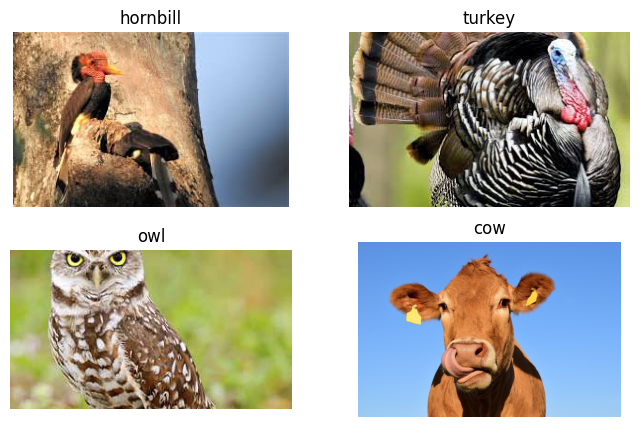

In [9]:
trainloader, validloader, testloader, dataset_sizes = create_dataloaders(ANIMALS_PATH)
dataloaders = {'train': trainloader, 'val': validloader, 'test': testloader}

##### Stylized Animals

----------Train-------------
                                            imgpath       labels
0         ./style_animals/train/goat/4f21ad4aa0.jpg         goat
1   ./style_animals/train/woodpecker/3a7fd9e840.jpg   woodpecker
2         ./style_animals/train/moth/9e81bc5555.jpg         moth
3        ./style_animals/train/shark/40f50c6990.jpg        shark
4  ./style_animals/train/hummingbird/8db010d774.jpg  hummingbird
(3779, 3)
--------Validation----------
                                         imgpath    labels
0     ./style_animals/train/koala/9ca7babf11.jpg     koala
1      ./style_animals/train/goat/2e7b3347db.jpg      goat
2       ./style_animals/train/pig/1d8c1f3bbd.jpg       pig
3  ./style_animals/train/seahorse/37aaf8c8d7.jpg  seahorse
4  ./style_animals/train/mosquito/7cc15cecf2.jpg  mosquito
(1134, 3)
----------Test--------------
                                         imgpath    labels
0     ./style_animals/train/otter/7c3868b76f.jpg     otter
1    ./style_animals/train/turt

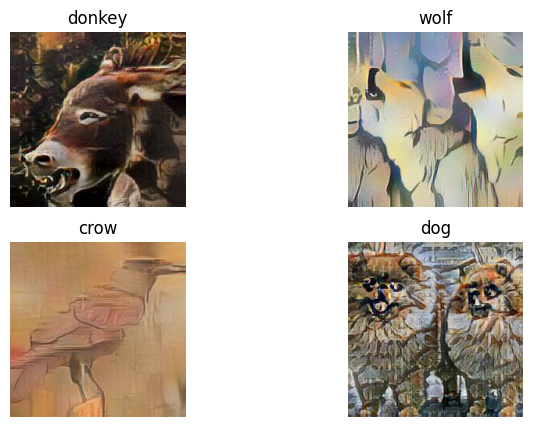

In [10]:
s_trainloader, s_validloader, s_testloader, s_dataset_sizes = create_dataloaders(STYLE_ANIMALS_PATH)
s_dataloaders = {'train': s_trainloader, 'val': s_validloader, 'test':s_testloader}

----------Train-------------
                                imgpath       labels
0         ./figures/goat/4f21ad4aa0.jpg         goat
1   ./figures/woodpecker/3a7fd9e840.jpg   woodpecker
2         ./figures/moth/9e81bc5555.jpg         moth
3        ./figures/shark/40f50c6990.jpg        shark
4  ./figures/hummingbird/8db010d774.jpg  hummingbird
(3779, 3)
--------Validation----------
                             imgpath    labels
0     ./figures/koala/9ca7babf11.jpg     koala
1      ./figures/goat/2e7b3347db.jpg      goat
2       ./figures/pig/1d8c1f3bbd.jpg       pig
3  ./figures/seahorse/37aaf8c8d7.jpg  seahorse
4  ./figures/mosquito/7cc15cecf2.jpg  mosquito
(1134, 3)
----------Test--------------
                             imgpath    labels
0     ./figures/otter/7c3868b76f.jpg     otter
1    ./figures/turtle/05e2720400.jpg    turtle
2     ./figures/whale/3b4307af02.jpg     whale
3      ./figures/lion/7d8f058238.jpg      lion
4  ./figures/seahorse/2cd0c57bad.jpg  seahorse
(487, 3)


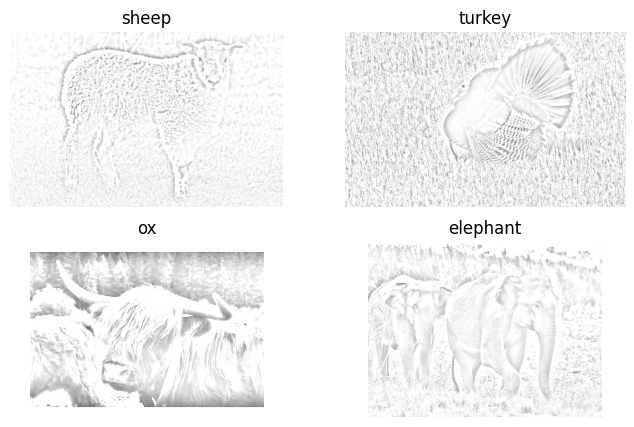

In [11]:
# Sketch animals
SKETCH_PATH = './figures/'

sh_trainloader, sh_validloader, sh_testloader, sh_dataset_sizes = create_dataloaders(SKETCH_PATH)
sh_dataloaders = {'train': sh_trainloader, 'val': sh_validloader, 'test': sh_testloader}

## Experimentation
1. Pretrained + no finetuning
2. Pretrained + finetuning

### pretrained + no finetuning

In [13]:
# pretrained + no finetuning
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 90)

print(model)

/home/intern/anaconda3/envs/kh_base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intern/anaconda3/envs/kh_base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


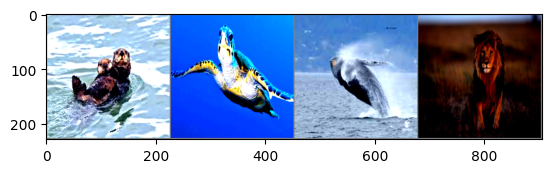

GroundTruth:  otter turtle whale lion 


In [15]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 1 %


#### Examine images from the final batch

We examine why the degree to which the model is confused with various classes.
In other words, is ResNet unreasonably incorrect? Are there obvious textual cues that might have led to the incorrect predictions?

In [17]:
predicted, labels

(tensor([49, 88, 88]), tensor([65,  2,  0]))

In [18]:
print('predicted: ', classes[39], '\t groundtruth: ', classes[79])

predicted:  hummingbird 	 groundtruth:  squirrel


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


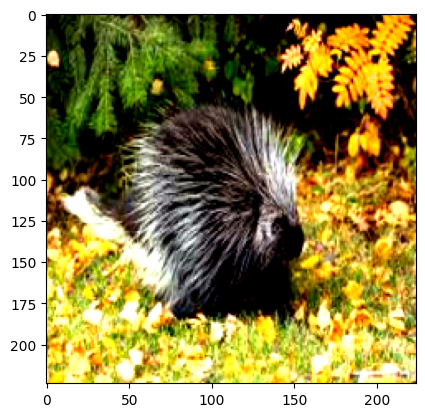

In [19]:
imshow(images[0])

It may be more complete to supplement more pictures of the squirrel class

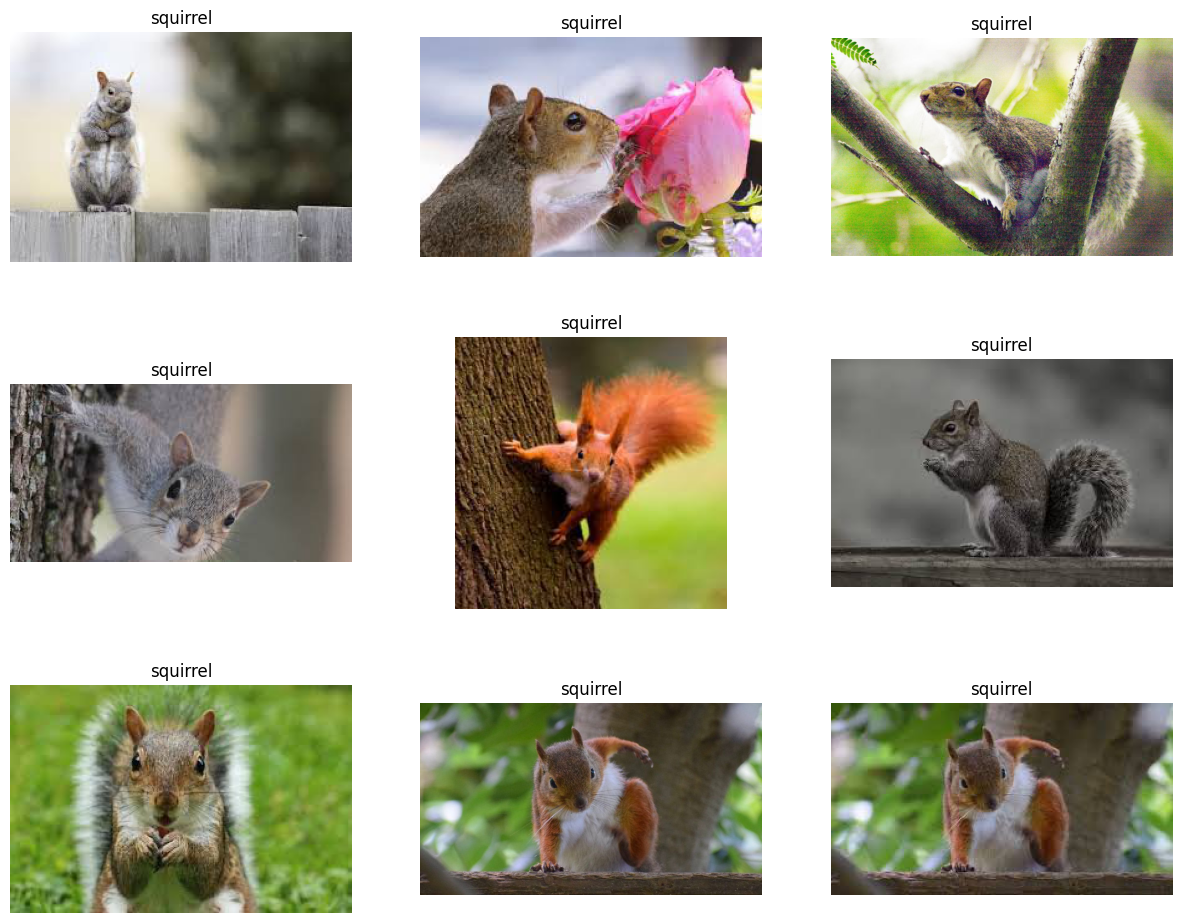

In [20]:
plt.figure(figsize=(15,12))

squirreldf = img_name = df[df['labels'] == 'squirrel']

for i, row in squirreldf.sample(n=9).reset_index().iterrows():
    plt.subplot(3,3,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [21]:
# Find the first row with label 'hummingbird'
df[df['labels'] == 'hummingbird'].iloc[0]

imgpath           ./animals/hummingbird/5e4cb50b7c.jpg
labels                                     hummingbird
encoded_labels                                      39
Name: 2040, dtype: object

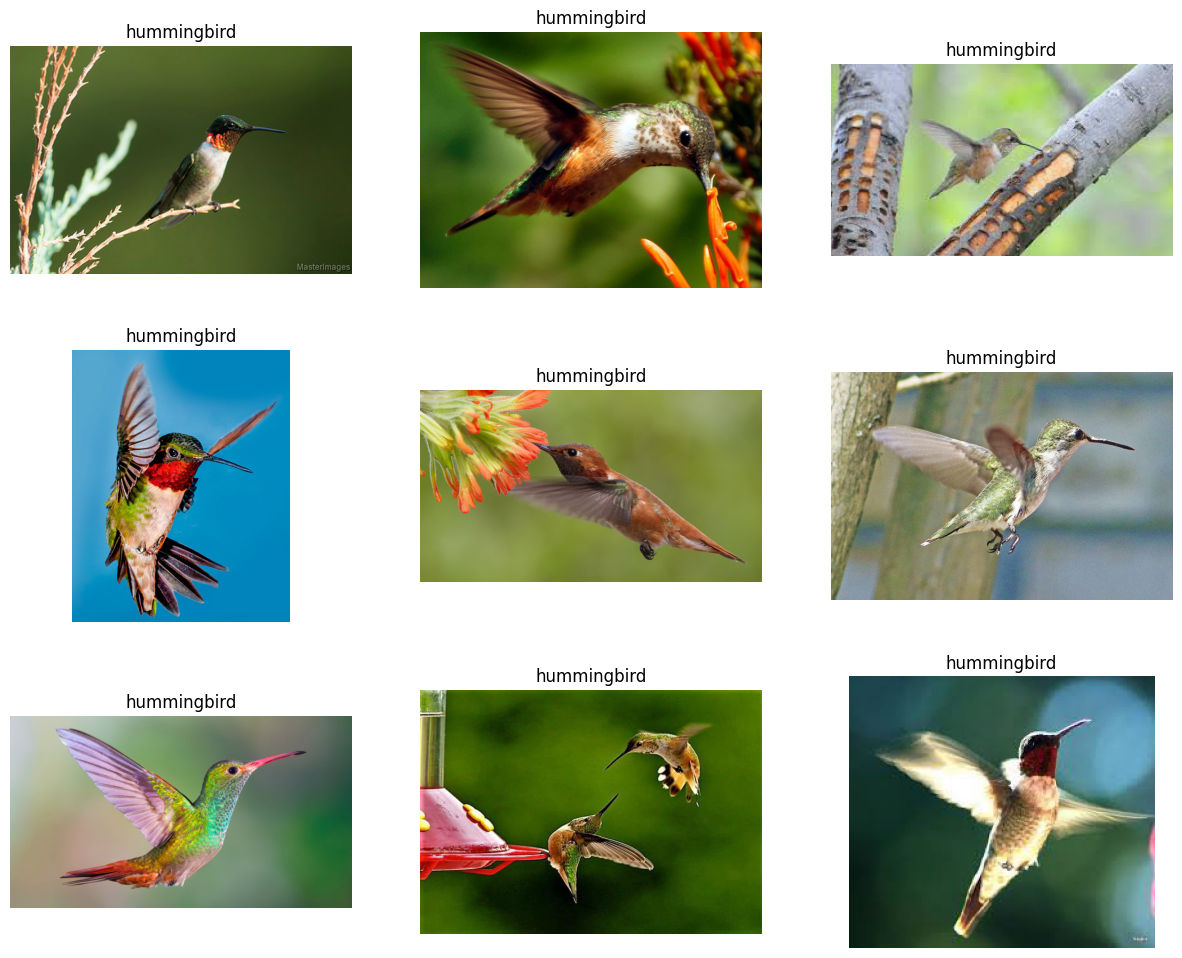

In [22]:
plt.figure(figsize=(15,12))

squirreldf = img_name = df[df['labels'] == 'hummingbird']

for i, row in squirreldf.sample(n=9).reset_index().iterrows():
    plt.subplot(3,3,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

- It is quite clear that the hummingbird class is very color and diverse in comparison to the squirrel class. This suggests this misclassification is NOT unreasonable.
- However, these may not be representative of the squirrel/hummingbird images in ImageNet. In fact, the ImageNet dataset contains squirrel and hummingbird classes.
- fox squirrel, eastern fox squirrel, Sciurus niger (class 335)
- hummingbird (class 94)
- Our model will likely only work after finetuning on the specialized animals-90 dataset.

Ref:
https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

##### Another example (hidden)

In [23]:
print('predicted: ', classes[9], '\t groundtruth: ', classes[28])

predicted:  cat 	 groundtruth:  goat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Image erroneously predicted as cat


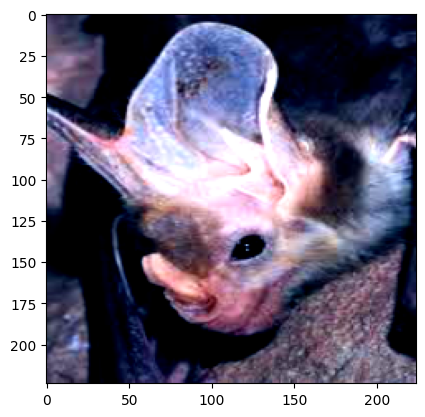

In [24]:
print('The Image erroneously predicted as cat')
imshow(images[1])

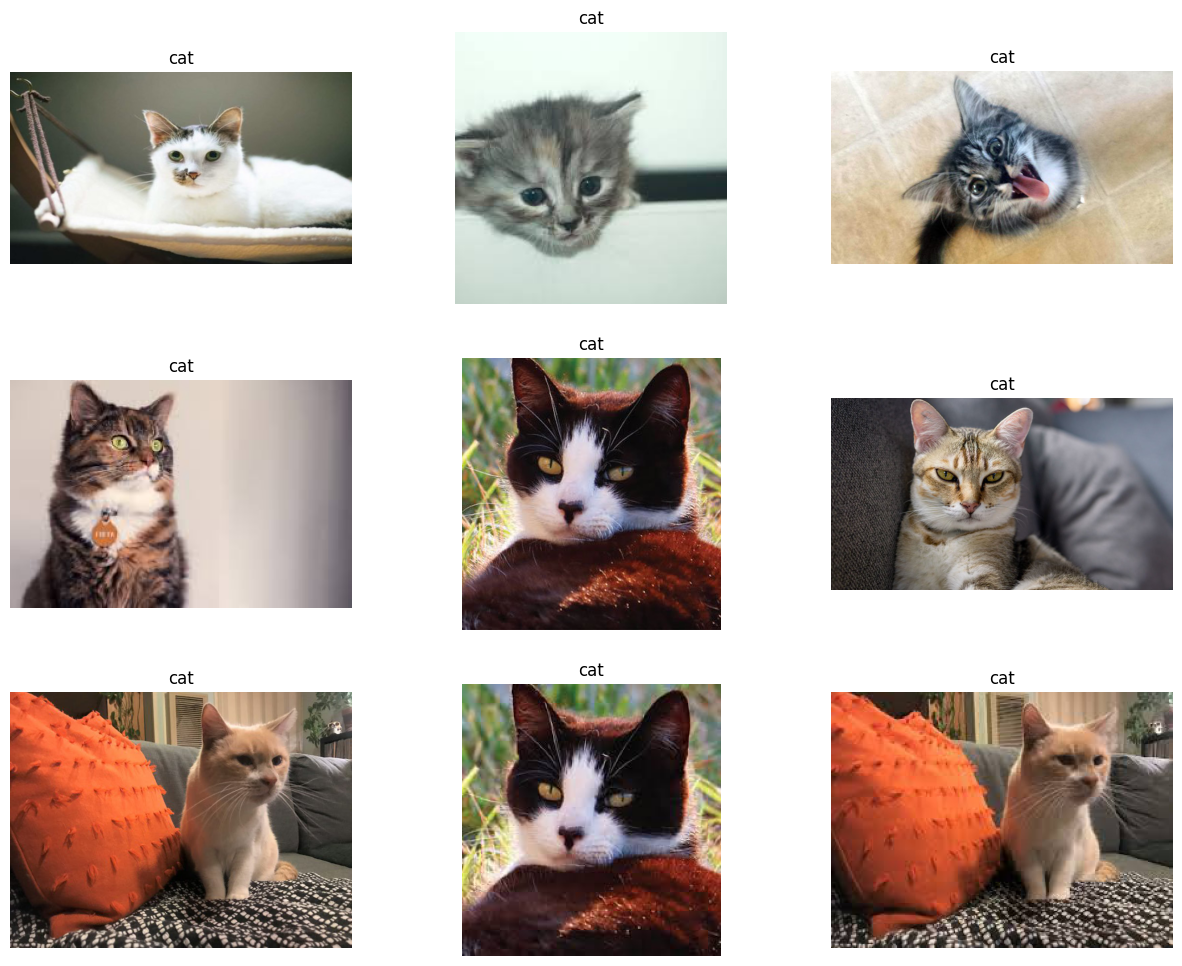

In [25]:
plt.figure(figsize=(15,12))

squirreldf = img_name = df[df['labels'] == 'cat']

for i, row in squirreldf.sample(n=9).reset_index().iterrows():
    plt.subplot(3,3,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

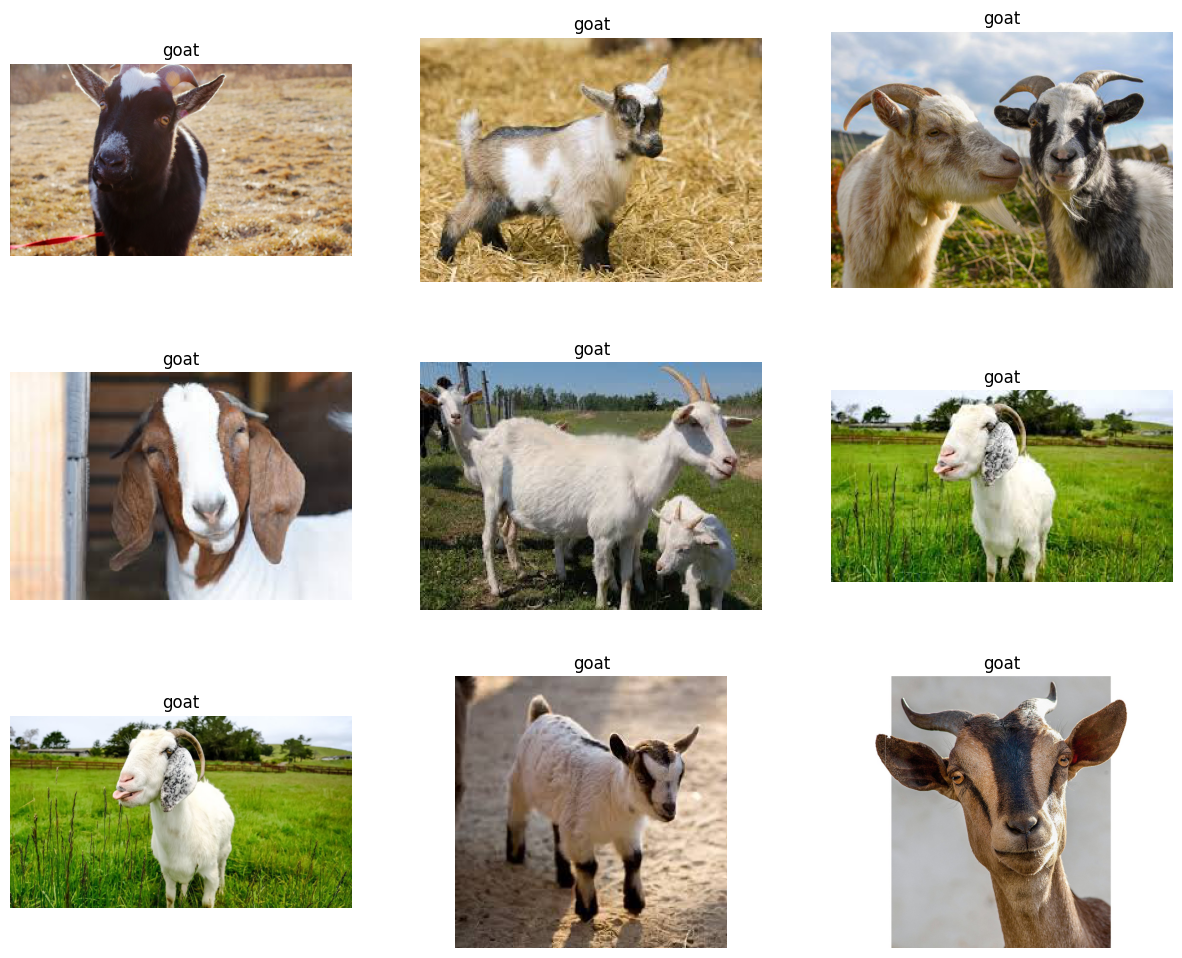

In [26]:
plt.figure(figsize=(15,12))

squirreldf = img_name = df[df['labels'] == 'goat']

for i, row in squirreldf.sample(n=9).reset_index().iterrows():
    plt.subplot(3,3,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

### Pretrain + finetune

Here we use the training + validation data to fit the pretrained model. Model performance is expected to increase greatly.

In [14]:
import time
# From Official Pytorch page: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

##### Accuracy and top-5 accuracy

In [13]:
def get_accuracy(model, testloader):

    model.eval()
    model = model.to(device)
    correct = 0
    total = 0
    predictions = list()

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Record predictions
            predictions.append(outputs)

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    return predictions

def top_5_accuracy(predictions, labels):
    _, top5_predictions = torch.topk(predictions, 5, dim=1)
    correct = top5_predictions.eq(labels.view(-1, 1).expand_as(top5_predictions))
    top5_acc = correct.sum().item() / len(labels)
    return top5_acc

##### ResNet 50

In [37]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 90)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.6518 Acc: 0.3856
val Loss: 0.8003 Acc: 0.7407

Epoch 1/24
----------
train Loss: 0.9598 Acc: 0.7730
val Loss: 0.5019 Acc: 0.8527

Epoch 2/24
----------
train Loss: 0.4811 Acc: 0.8918
val Loss: 0.5236 Acc: 0.8616

Epoch 3/24
----------
train Loss: 0.2652 Acc: 0.9503
val Loss: 0.4391 Acc: 0.8818

Epoch 4/24
----------
train Loss: 0.1485 Acc: 0.9722
val Loss: 0.3884 Acc: 0.9039

Epoch 5/24
----------
train Loss: 0.1239 Acc: 0.9762
val Loss: 0.4314 Acc: 0.9012

Epoch 6/24
----------
train Loss: 0.0883 Acc: 0.9849
val Loss: 0.4219 Acc: 0.8933

Epoch 7/24
----------
train Loss: 0.0626 Acc: 0.9907
val Loss: 0.3967 Acc: 0.9021

Epoch 8/24
----------
train Loss: 0.0452 Acc: 0.9944
val Loss: 0.3995 Acc: 0.9030

Epoch 9/24
----------
train Loss: 0.0519 Acc: 0.9915
val Loss: 0.3700 Acc: 0.9118

Epoch 10/24
----------
train Loss: 0.0393 Acc: 0.9939
val Loss: 0.3590 Acc: 0.9118

Epoch 11/24
----------
train Loss: 0.0368 Acc: 0.9944
val Loss: 0.3749 Acc: 0.9109

Ep

In [55]:
# save weights
save_path = './resnet50_weights.pth'

# Save the model's state_dict to the specified file
torch.save(model_ft.state_dict(), save_path)

##### Oct31 - load saved weights

In [17]:
# Get model
model_ft = models.resnet50()
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 90)

# rename for convenience
res50 = model_ft

# Load saved weights
save_path = './resnet50_weights.pth'
res50_w = torch.load(save_path)

res50.load_state_dict(res50_w)
res50 = res50.to(device)

In [18]:
predictions = get_accuracy(res50, testloader)

Test Accuracy: 91.17%


In [35]:
res50.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = res50(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 97.88%


##### Test on sketch

In [19]:
predictions = get_accuracy(res50, sh_testloader)

Test Accuracy: 32.24%


In [20]:
res50.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in sh_testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = res50(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 57.86%


##### Res18

In [63]:
res18 = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = res18.fc.in_features
res18.fc = nn.Linear(num_ftrs, len(classes))

res18 = res18.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

res18 = train_model(res18, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


train Loss: 2.8699 Acc: 0.3263
val Loss: 1.0986 Acc: 0.6790

Epoch 1/24
----------
train Loss: 1.1719 Acc: 0.7256
val Loss: 0.7083 Acc: 0.7937

Epoch 2/24
----------
train Loss: 0.6064 Acc: 0.8701
val Loss: 0.5751 Acc: 0.8457

Epoch 3/24
----------
train Loss: 0.3156 Acc: 0.9439
val Loss: 0.5393 Acc: 0.8571

Epoch 4/24
----------
train Loss: 0.1861 Acc: 0.9733
val Loss: 0.5016 Acc: 0.8624

Epoch 5/24
----------
train Loss: 0.1174 Acc: 0.9862
val Loss: 0.5099 Acc: 0.8624

Epoch 6/24
----------
train Loss: 0.0896 Acc: 0.9897
val Loss: 0.4900 Acc: 0.8730

Epoch 7/24
----------
train Loss: 0.0626 Acc: 0.9955
val Loss: 0.4544 Acc: 0.8730

Epoch 8/24
----------
train Loss: 0.0566 Acc: 0.9952
val Loss: 0.4364 Acc: 0.8810

Epoch 9/24
----------
train Loss: 0.0584 Acc: 0.9936
val Loss: 0.4414 Acc: 0.8730

Epoch 10/24
----------
train Loss: 0.0528 Acc: 0.9947
val Loss: 0.4427 Acc: 0.8792

Epoch 11/24
----------
train Loss: 0.0443 Acc: 0.9971
val Loss: 0.4474 Acc: 0.8748

Epoch 12/24
----------
t

In [64]:
GetTestAcc(res18)

Accuracy of the network on the test images: 88 %


In [65]:
# save weights
save_path = './resnet18_weights.pth'

# Save the model's state_dict to the specified file
torch.save(res18.state_dict(), save_path)

We observe that the increase in accuracy is marginal between ResNet-18 and ResNet-50. We opt to experiment with the smaller ResNet-18 model moving forward.

### Which classes did ResNet get wrong?

In [48]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = res18(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


accuracy_data = {'Class Name': [], 'Accuracy (%)': []}
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    accuracy_data['Class Name'].append(classname)
    accuracy_data['Accuracy (%)'].append(accuracy)

accuracy_df = pd.DataFrame(accuracy_data)

In [57]:
perfect_accuracy_rows = accuracy_df[accuracy_df['Accuracy (%)'] == 100.0]

# Calculate the percentage of perfect accuracy rows
percentage_perfect_accuracy = (len(perfect_accuracy_rows) / len(accuracy_df)) * 100

print(f"Percentage of Perfect Accuracy Rows: {percentage_perfect_accuracy:.2f}%")

Percentage of Perfect Accuracy Rows: 68.89%


We now examine the classes that are NOT perfect

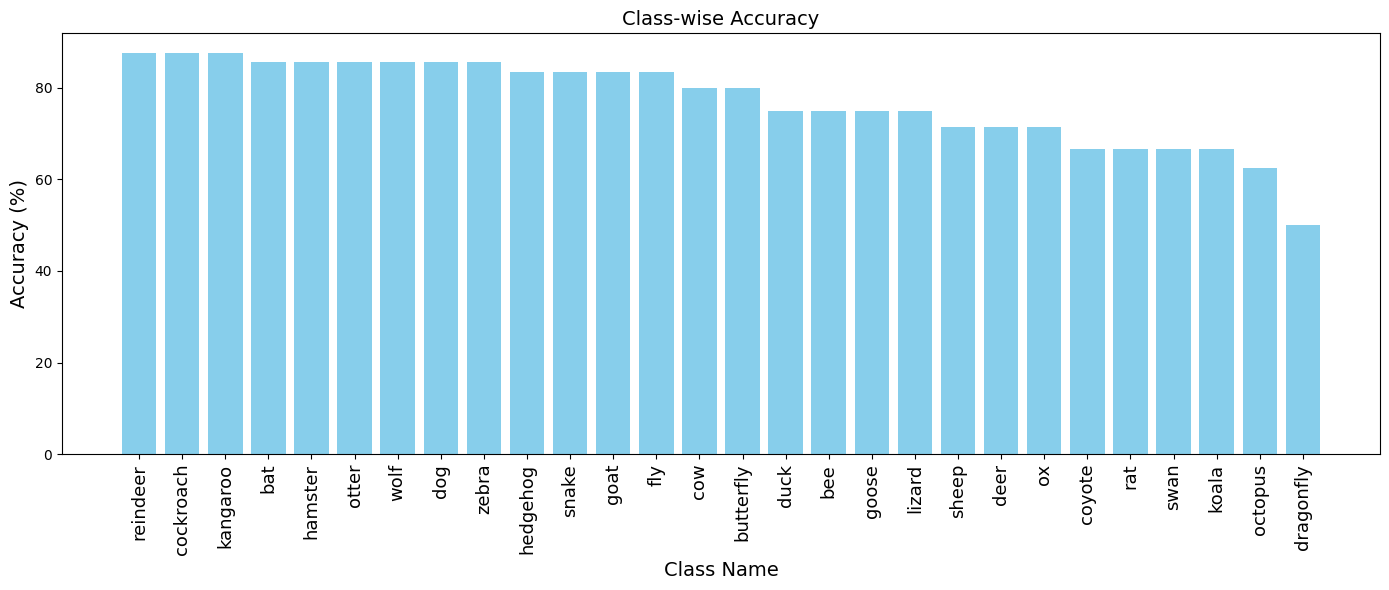

In [62]:
imperfect_df = accuracy_df[accuracy_df['Accuracy (%)'] != 100.0]
imperfect_df = imperfect_df.sort_values(by='Accuracy (%)', ascending=False)

# Set the class name as the x-axis and accuracy as the y-axis
class_names = imperfect_df['Class Name']
accuracies = imperfect_df['Accuracy (%)']

# Create a bar chart
plt.figure(figsize=(14, 6))
plt.bar(class_names, accuracies, color='skyblue')
plt.xlabel('Class Name', fontsize= 14)
plt.ylabel('Accuracy (%)', fontsize= 14)
plt.title('Class-wise Accuracy', fontsize = 14)
plt.xticks(rotation=90, fontsize=13)

plt.tight_layout()
plt.show()

#### Let us examine a few instances where the model got wrong